<a href="https://colab.research.google.com/github/nitixsh/CNN-BILSTM_IDS-Project/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================
# IMPORT LIBRARIES
# ==============================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv("/content/cicids2017_cleaned.csv")

df.columns = df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)


In [3]:
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()

if "Label" in non_numeric:
    non_numeric.remove("Label")

df.drop(columns=non_numeric, inplace=True)


In [4]:
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])
class_names = le.classes_


In [5]:
X = df.drop("Label", axis=1)
y = df["Label"]

selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=100 is greater than n_features=66. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [31 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=256, shuffle=True)

test_loader = DataLoader(TensorDataset(X_test, y_test),
                         batch_size=256)


In [8]:
class CNNTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.flatten_dim = (input_dim // 4) * 128

        self.embedding = nn.Linear(self.flatten_dim, 256)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=3
        )

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.flatten(1)
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.dropout(x)
        return self.fc(x)


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()


In [11]:
model = CNNTransformer(X_train.shape[1], len(class_names)).to(device)

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003)

train_losses = []
test_accuracies = []

for epoch in range(30):

    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()

    acc = 100 * correct / total

    train_losses.append(total_loss)
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}, Loss={total_loss:.4f}, Accuracy={acc:.2f}%")

torch.save(model.state_dict(), "best_model1.pth")


Epoch 1, Loss=5.4405, Accuracy=99.89%
Epoch 2, Loss=1.1217, Accuracy=99.94%
Epoch 3, Loss=0.9523, Accuracy=99.89%
Epoch 4, Loss=1.3060, Accuracy=99.92%
Epoch 5, Loss=1.1493, Accuracy=99.90%
Epoch 6, Loss=0.8668, Accuracy=99.92%
Epoch 7, Loss=0.8361, Accuracy=99.95%
Epoch 8, Loss=0.6298, Accuracy=99.88%
Epoch 9, Loss=0.9409, Accuracy=99.84%
Epoch 10, Loss=0.7105, Accuracy=99.95%
Epoch 11, Loss=0.4731, Accuracy=99.94%
Epoch 12, Loss=0.7266, Accuracy=99.93%
Epoch 13, Loss=1.6884, Accuracy=99.94%
Epoch 14, Loss=0.8000, Accuracy=99.93%
Epoch 15, Loss=0.8031, Accuracy=99.95%
Epoch 16, Loss=0.4810, Accuracy=99.95%
Epoch 17, Loss=0.4937, Accuracy=99.95%
Epoch 18, Loss=0.6272, Accuracy=99.92%
Epoch 19, Loss=0.7272, Accuracy=99.33%
Epoch 20, Loss=0.7319, Accuracy=99.93%
Epoch 21, Loss=0.4451, Accuracy=99.95%
Epoch 22, Loss=0.5074, Accuracy=99.92%
Epoch 23, Loss=1.2011, Accuracy=99.82%
Epoch 24, Loss=1.3768, Accuracy=99.93%
Epoch 25, Loss=0.6118, Accuracy=99.95%
Epoch 26, Loss=0.5000, Accuracy=99

In [12]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    probs = F.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probs, 1)

pred_labels = le.inverse_transform(predicted.cpu().numpy())
confidence_scores = confidence.cpu().numpy() * 100


In [13]:
severity_map = {
    "BENIGN": "Safe",
    "PortScan": "Low",
    "Bot": "Medium",
    "DoS Hulk": "High",
    "DDoS": "Critical"
}

severity_levels = [severity_map.get(a, "High") for a in pred_labels]


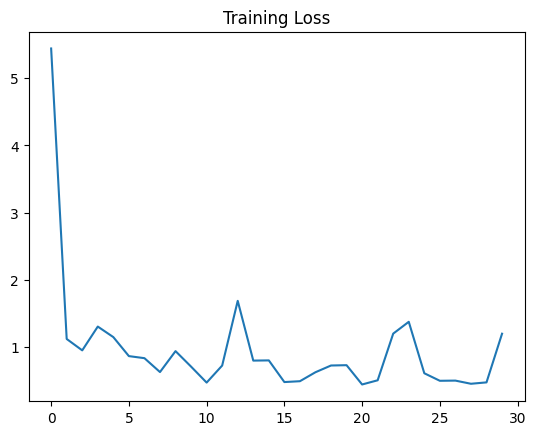

In [14]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()


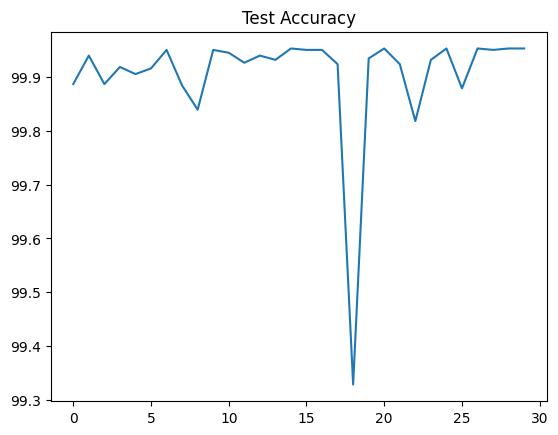

In [15]:
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.show()


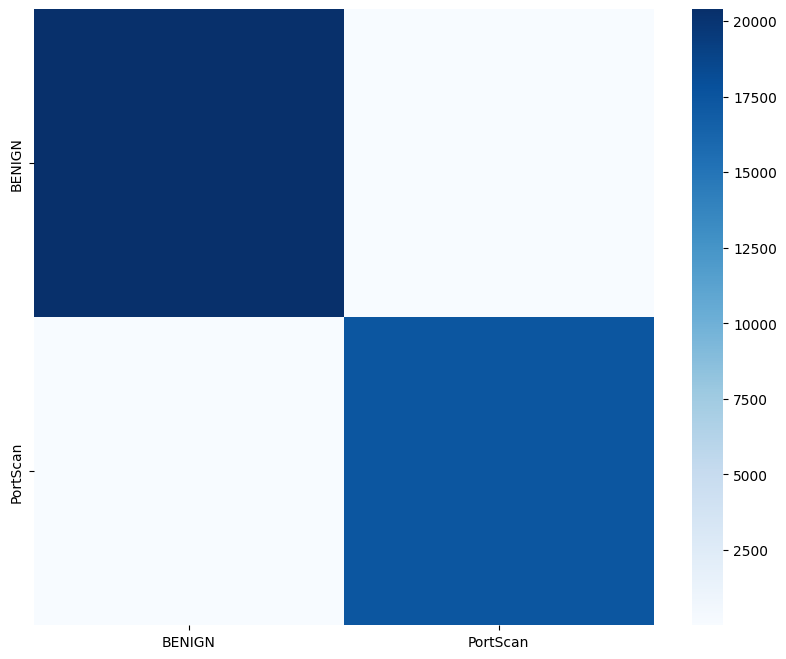

In [16]:
cm = confusion_matrix(
    le.inverse_transform(y_test.cpu().numpy()),
    pred_labels
)

plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.show()
